In [1]:
# TODO: exploratory data analysis 

In [2]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted


/Users/oliviazhang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/oliviazhang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/oliviazhang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DATA_ROOT = '../data'
clincopathology = pd.read_csv(os.path.join(DATA_ROOT, 'clincopathology_features.csv'))
clinical = pd.read_csv(os.path.join(DATA_ROOT, 'clinical_features.csv'))
pathology = pd.read_csv(os.path.join(DATA_ROOT, 'pathology_features.csv'))
# TODO: extract outcome (stored as 'diagnosis' column in each of these csv diles)

## Get the most common subtype as our target 

In [4]:
outcomes = clincopathology['diagnosis']
outcomes

0      2
1      1
2      3
3      1
4      3
      ..
361    4
362    4
363    3
364    3
365    1
Name: diagnosis, Length: 366, dtype: int64

In [5]:
outcomes.value_counts()

diagnosis
1    112
3     72
2     61
5     52
4     49
6     20
Name: count, dtype: int64

## see if missing age values are important by plsr

In [6]:
clinical

,pid,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,family_history,age,diagnosis
0,1,2,2,0,3,0,0,0,0,1,0,0,55.0,2
1,2,3,3,3,2,1,0,0,0,1,1,1,8.0,1
2,3,2,1,2,3,1,3,0,3,0,0,0,26.0,3
3,4,2,2,2,0,0,0,0,0,3,2,0,40.0,1
4,5,2,3,2,2,2,2,0,2,0,0,0,45.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,362,2,1,1,0,1,0,0,0,0,0,0,25.0,4
362,363,3,2,1,0,1,0,0,0,0,0,0,36.0,4
363,364,3,2,2,2,3,2,0,2,0,0,0,28.0,3
364,365,2,1,3,1,2,3,0,2,0,0,0,50.0,3


In [7]:
clinical_clean = clinical.dropna()
pathology_clean = pathology.dropna()
clincopathology_clean = clincopathology.dropna()

In [8]:
clincopathology_X = clincopathology_clean.drop(columns='diagnosis')
clincopathology_y = clincopathology_clean['diagnosis']

pathology_clean_X = pathology_clean.drop(columns='diagnosis')
pathology_clean_y = pathology_clean['diagnosis']

clinical_clean_X = clinical_clean.drop(columns='diagnosis')
clinical_clean_y = clinical_clean['diagnosis']


In [9]:
def calculate_and_plot_vip(plsr, X):
    """Calculate and plot VIP scores for PLS regression."""
    check_is_fitted(plsr)
    
    # Extract relevant components from the fitted pipeline
    T = plsr.named_steps['plsr'].x_scores_
    W = plsr.named_steps['plsr'].x_weights_
    Q = plsr.named_steps['plsr'].y_loadings_
    p, h = W.shape  # p = number of predictors, h = number of components
    s = np.diag(T.T @ T @ Q.T @ Q).reshape(h, -1)  # Explained variance by components
    total_s = np.sum(s)  # Total variance explained
    
    # Calculate VIP scores
    vip_scores = np.sqrt(p * np.sum((W**2) * s.T / total_s, axis=1))
    
    # Sort VIP scores and corresponding variables
    sorted_indices = np.argsort(vip_scores)[::-1]  # Indices of scores sorted in descending order
    sorted_vip_scores = vip_scores[sorted_indices]
    sorted_variables = X.columns[sorted_indices]

    # Plot VIP scores
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_variables, sorted_vip_scores, color='steelblue')  # Use sorted column names
    plt.xlabel('Variables')
    plt.ylabel('VIP Score')
    plt.title('Variable Importance in Projection (VIP) Scores')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return

In [10]:
plsr = Pipeline([
    ('scaler', StandardScaler()),
    ('plsr', PLSRegression(n_components=2))
])


In [11]:
plsr.fit(clincopathology_X, clincopathology_y)


Pipeline(steps=[('scaler', StandardScaler()), ('plsr', PLSRegression())])

In [12]:
# Extract coefficients
coefficients = plsr.named_steps['plsr'].coef_

# Identify importance of age
age_coefficient = coefficients[-1]  # Last coefficient corresponds to age
print(f"Age Coefficient: {age_coefficient}")

Age Coefficient: [-0.09515698]


/Users/oliviazhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


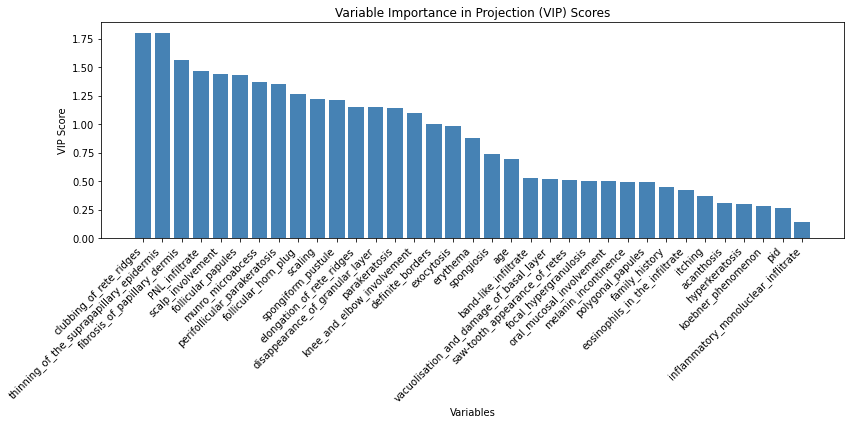

In [13]:
calculate_and_plot_vip(plsr, clincopathology_X)


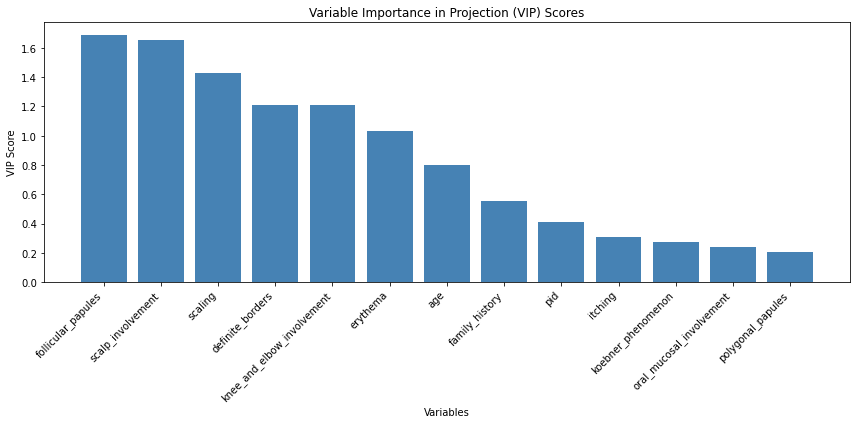

In [14]:
plsr.fit(clinical_clean_X, clinical_clean_y)
calculate_and_plot_vip(plsr, clinical_clean_X)


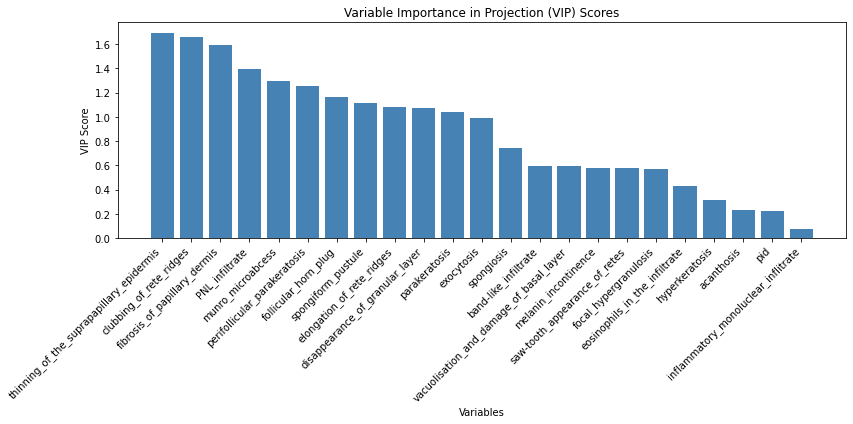

In [15]:
plsr.fit(pathology_clean_X, pathology_clean_y)
calculate_and_plot_vip(plsr, pathology_clean_X)

## age is of medium importance, use kNN to predict missing age. Predict based on clincopathology bc more variables. Predicters not including diagnoisis 

In [16]:
predictors = clincopathology.drop(columns=['age', 'diagnosis'])
imputer = KNNImputer(n_neighbors=5, weights='distance')  # weights='distance' for weighted averaging

na_mask = clincopathology['age'].isnull()

clincopathology_filled_na = clincopathology.copy()  # Make a copy of the original data
clincopathology_filled_na.iloc[:, :] = imputer.fit_transform(clincopathology)

clincopathology_filled_na[na_mask]



,pid,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,...,disappearance_of_granular_layer,vacuolisation_and_damage_of_basal_layer,spongiosis,saw-tooth_appearance_of_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_inflitrate,band-like_infiltrate,age,diagnosis
33,34,2,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,31.104782,1
34,35,2,1,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,29.823436,4
35,36,2,2,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29.514103,2
36,37,2,1,2,3,2,3,0,2,0,...,0,2,0,2,0,0,0,3,29.613763,3
262,263,2,1,0,2,0,0,0,0,0,...,0,0,2,0,0,0,3,0,32.786746,5
263,264,1,1,1,3,0,0,0,0,0,...,0,0,3,0,0,0,2,0,23.849893,5
264,265,1,1,0,2,0,0,0,0,1,...,0,0,2,0,0,0,3,0,20.579672,5
265,266,1,1,0,3,0,0,0,0,0,...,0,0,2,0,0,0,3,0,19.626921,5


In [17]:
clinical[na_mask]

,pid,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,family_history,age,diagnosis
33,34,2,2,1,0,0,0,0,0,1,0,1,NaN,1
34,35,2,1,0,0,2,0,0,0,0,0,0,NaN,4
35,36,2,2,1,2,0,0,0,0,0,0,0,NaN,2
36,37,2,1,2,3,2,3,0,2,0,0,1,NaN,3
262,263,2,1,0,2,0,0,0,0,0,0,0,NaN,5
263,264,1,1,1,3,0,0,0,0,0,0,0,NaN,5
264,265,1,1,0,2,0,0,0,0,1,0,0,NaN,5
265,266,1,1,0,3,0,0,0,0,0,0,0,NaN,5


In [18]:
clinical_filled_na = clinical.copy()
clinical_filled_na.loc[na_mask,'age'] = clincopathology_filled_na.loc[na_mask,'age']

In [19]:
clinical_filled_na.loc[na_mask]

,pid,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,family_history,age,diagnosis
33,34,2,2,1,0,0,0,0,0,1,0,1,31.104782,1
34,35,2,1,0,0,2,0,0,0,0,0,0,29.823436,4
35,36,2,2,1,2,0,0,0,0,0,0,0,29.514103,2
36,37,2,1,2,3,2,3,0,2,0,0,1,29.613763,3
262,263,2,1,0,2,0,0,0,0,0,0,0,32.786746,5
263,264,1,1,1,3,0,0,0,0,0,0,0,23.849893,5
264,265,1,1,0,2,0,0,0,0,1,0,0,20.579672,5
265,266,1,1,0,3,0,0,0,0,0,0,0,19.626921,5


In [20]:
clinical_filled_na.to_csv(os.path.join(DATA_ROOT, 'clinical_features_filled_na.csv'))
clincopathology_filled_na.to_csv(os.path.join(DATA_ROOT, 'clincopathology_features_filled_na.csv'))


## PCA

In [21]:
clinicopath_variables = clincopathology.drop(columns=['diagnosis', 'pid', 'age'])
clinical_variables = clinical.drop(columns=['diagnosis', 'pid', 'age'])
path_variables = pathology.drop(columns=['diagnosis', 'pid'])
# outcomes stored in variable outcomes 
diagnosis2name = {
    1: 'psoriasis',
    2: 'seboreic dermatitis',
    3: 'lichen planus',
    4: 'pityriasis rosea',
    5: 'cronic dermatitis',
    6: 'pityriasis rubra pilaris',
}


In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

combined_data = pd.concat([clinicopath_variables, clinical_variables, path_variables], axis=1)
scaler = StandardScaler()
standardized_data = scaler.fit_transform(combined_data)

# PCA
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(standardized_data)
pca_loadings = pca.components_.T  # Loadings are the components matrix

# scores 
pca_df = pd.DataFrame(pca_scores, columns=['PC1', 'PC2'])
pca_df['Outcome'] = outcomes

# loadings 
variables = combined_data.columns
loadings_df = pd.DataFrame(pca_loadings, columns=['PC1', 'PC2'], index=variables)


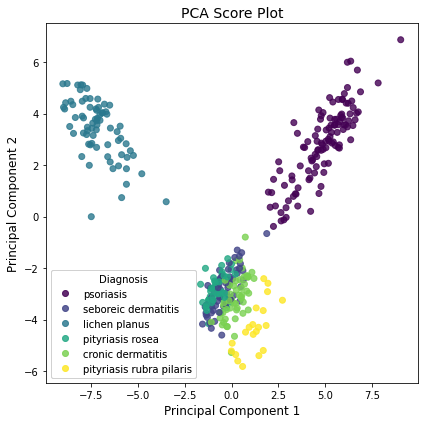

In [23]:
# Score plot (colored by outcome)
pca_df['Outcome Name'] = pca_df['Outcome'].map(diagnosis2name)

# Plot with updated legend
fig, ax = plt.subplots(figsize=(6, 6))

# Score plot (colored by outcome)
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Outcome'], cmap='viridis', alpha=0.8)

# Update the legend to display names instead of numeric labels
handles, labels = scatter.legend_elements()
mapped_labels = [diagnosis2name[int(label.strip('$\\mathdefault{}'))] for label in labels]
legend1 = ax.legend(handles, mapped_labels, title="Diagnosis")
ax.add_artist(legend1)

# Set titles and labels
ax.set_title('PCA Score Plot', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)

plt.tight_layout()
plt.show()


## Demographics and summary statistics 

In [32]:
clinical_variables_with_age = clinical.drop(columns=['diagnosis', 'pid'])

In [34]:
outcomes_df = pd.DataFrame({
    'diagnosis': outcomes,
    'subtype_name': outcomes.map(diagnosis2name)
})
# 1) count each diagnosis subtype and calculate percentage
subtype_counts = outcomes_df['subtype_name'].value_counts()
subtype_percentages = (subtype_counts / len(outcomes_df)) * 100
subtype_summary = pd.DataFrame({
    'Count': subtype_counts,
    'Percentage': subtype_percentages
})
print(subtype_summary)
# 2) mean age
mean_age = clinical_variables_with_age['age'].mean()
print(mean_age)

                          Count  Percentage
subtype_name                               
psoriasis                   112   30.601093
lichen planus                72   19.672131
seboreic dermatitis          61   16.666667
cronic dermatitis            52   14.207650
pityriasis rosea             49   13.387978
pityriasis rubra pilaris     20    5.464481
36.29608938547486


In [35]:
len(outcomes_df)

366